In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
with open("../data/names.txt", "r") as file:
    words = file.read().splitlines()

words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(stoi)
print(itos)
vocab_size = len(stoi)
print("vocab_size: ", vocab_size)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
vocab_size:  27


In [4]:
block_size = 3

X, Y = [], []

for w in words[:3]:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print("".join(itos[i] for i in context), "--->", itos[ix])
        context = context[1:] + [ix]

... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
... ---> a
..a ---> v
.av ---> a
ava ---> .


In [5]:
# build the dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, X.dtype, Y.shape, Y.dtype)
    return X, Y

random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.int64 torch.Size([182625]) torch.int64
torch.Size([22655, 3]) torch.int64 torch.Size([22655]) torch.int64
torch.Size([22866, 3]) torch.int64 torch.Size([22866]) torch.int64


In [6]:
for i in range(7):
    print("Input: ", Xtr[i].tolist()," Target: ", Ytr[i].item())
    print("Input: ", "".join((itos[w]) for w in Xtr[i].tolist()), " Target: ", itos[Ytr[i].item()])


Input:  [0, 0, 0]  Target:  25
Input:  ...  Target:  y
Input:  [0, 0, 25]  Target:  21
Input:  ..y  Target:  u
Input:  [0, 25, 21]  Target:  8
Input:  .yu  Target:  h
Input:  [25, 21, 8]  Target:  5
Input:  yuh  Target:  e
Input:  [21, 8, 5]  Target:  14
Input:  uhe  Target:  n
Input:  [8, 5, 14]  Target:  7
Input:  hen  Target:  g
Input:  [5, 14, 7]  Target:  0
Input:  eng  Target:  .


In [10]:

class MLP(nn.Module):
    def __init__(self, vocab_size, n_embd, block_size, n_hidden, use_norm_layer=True):
        super(MLP, self).__init__()
        # Create the embedding table
        self.embedding_table = nn.Embedding(vocab_size, n_embd)
        
        # Define the sequence of layers
        layers = [
            nn.Linear(n_embd * block_size, n_hidden),
            nn.LayerNorm(n_hidden) if use_norm_layer else nn.Identity(),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden),
            nn.LayerNorm(n_hidden) if use_norm_layer else nn.Identity(),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden),
            nn.LayerNorm(n_hidden) if use_norm_layer else nn.Identity(),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden),
            nn.LayerNorm(n_hidden) if use_norm_layer else nn.Identity(),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden),
            nn.LayerNorm(n_hidden) if use_norm_layer else nn.Identity(),
            nn.Tanh(),
            nn.Linear(n_hidden, vocab_size),
            nn.LayerNorm(vocab_size) if use_norm_layer else nn.Identity()
        ]
        
        # Create a sequential container
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        # Forward pass through the embedding table
        x = self.embedding_table(x)  # shape: (batch_size, block_size, n_embd)
        # Flatten the embeddings
        x = x.view(x.size(0), -1)  # shape: (batch_size, block_size * n_embd)
        # Forward pass through the MLP layers
        x = self.layers(x)  # shape: (batch_size, vocab_size)
        return x

# Define parameters
vocab_size = 27      # as per your requirement
n_embd = 10          # you can choose this value as needed
block_size = 3       # number of input characters
n_hidden = 100       # size of the hidden layer
use_norm_layer = False  # flag to use normalization layer
lr_init = 0.01

# Check for CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create an instance of the MLP class
model = MLP(vocab_size, n_embd, block_size, n_hidden, use_norm_layer).to(device)

# Define the optimizer
optimizer = optim.AdamW(model.parameters(), lr=lr_init, weight_decay=0.01, betas=(0.9, 0.999), eps=1e-08)

# Make datasets
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

training on cuda
torch.Size([182625, 3]) torch.int64 torch.Size([182625]) torch.int64
torch.Size([22655, 3]) torch.int64 torch.Size([22655]) torch.int64
torch.Size([22866, 3]) torch.int64 torch.Size([22866]) torch.int64


In [11]:
max_steps = 200000
batch_size = 32
lossi = []

Xtr, Ytr = Xtr.to(device), Ytr.to(device)

for i in range(max_steps):
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), device=device)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward pass
    optimizer.zero_grad()
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    
    # Backward pass
    loss.backward()
    
    # Update
    if i == int(2/3 * max_steps):
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr_init / 10
    optimizer.step()
    
    # Track stats
    if i % 5000 == 0:
        print(f"{i:7d} /{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.item())

    if i > 10000:
        break

RuntimeError: Expected target size [32, 27], got [32]

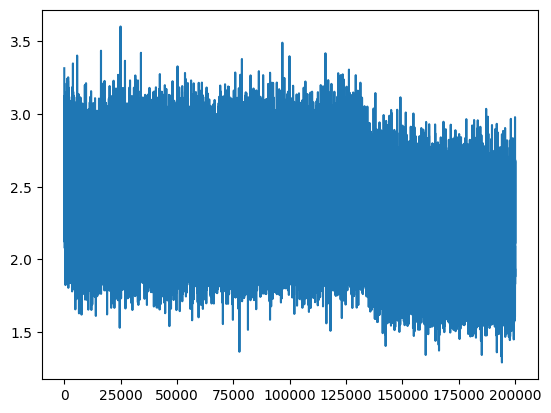

In [19]:
plt.plot(lossi);

In [20]:
Xdev, Ydev = Xdev.to(device), Ydev.to(device)

@torch.no_grad()
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split]

    # forward pass
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    logits = model(embcat)
    loss = F.cross_entropy(logits, y)


    # # -------------
    # emb = C[x]
    # embcat = emb.view(emb.shape[0], -1)
    # h = torch.tanh(embcat @ W1 + b1)  
    # logits = h @ W2 + b2                                           
    # loss = F.cross_entropy(logits, y)
    print(f"{split}: {loss.item():.4f}")

split_loss("train")
split_loss("val")    

train: 2.1162
val: 2.1516


In [41]:
if n_embd == 2:
    plt.figure(figsize=(8,8))
    plt.scatter(C[:,0].data, C[:,1].data, s=200)
    for i in range(C.shape[0]):
        plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
    plt.grid("minor");

In [23]:
# Sampling function
with torch.no_grad():
    for _ in range(20):
        model.eval()
        out = []
        context = [0] * block_size
        while True:
            emb = C[torch.tensor([context])]
            x = emb.view(emb.shape[0], -1)
            x = model(x)
            probs = F.softmax(x, dim=1)
            ix = torch.multinomial(probs, num_samples=1).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break
        print("".join(itos[i] for i in out))

ley.
mushale.
kalie.
abbier.
mene.
gifaina.
emim.
kelnyana.
armani.
bebabylyn.
ager.
fyri.
nielyn.
aamiyolos.
izenaree.
hasavalonna.
ela.
qwali.
tranaia.
harian.


In [35]:
print(C.shape)
print(C)

torch.Size([27, 10])
tensor([[-0.1190,  0.5687,  0.1476,  0.3374,  0.2066, -0.2591, -0.3230, -0.5716,
         -0.4979, -0.3566],
        [ 0.0698,  0.2024,  0.6374, -0.2194, -0.1573,  0.7402,  0.3282, -0.0537,
         -0.2743,  0.1161],
        [-0.5098, -0.1099, -0.2583,  0.1422, -0.2168, -0.5813,  0.2249,  0.6067,
         -0.8765,  0.1245],
        [-1.0207, -0.7749,  0.5848,  0.6172,  0.0062,  0.0141, -0.9694,  0.1246,
          0.4502,  0.3415],
        [-0.2549, -0.0235, -0.3927, -0.1982, -0.6007,  0.0079,  0.0132,  0.1153,
         -0.1278,  0.4082],
        [ 0.2678,  0.3744,  0.0046, -0.5984,  0.1023,  0.1480, -0.1525,  0.6580,
          0.0269,  0.1475],
        [ 0.0039,  0.0895, -0.5743,  0.4658, -0.0858, -0.5028,  0.0321,  0.1422,
         -0.2659,  0.7852],
        [-0.3172, -0.5937,  0.1878,  0.3010,  0.3354, -0.3990,  0.1213,  0.4644,
         -0.5182,  0.8167],
        [ 0.2533, -0.4254, -0.1808,  0.4299, -0.3147, -0.3484,  0.9915, -0.6110,
         -0.3622,  0.2308]

In [36]:
inp = [0] * block_size
print(inp)
context = torch.tensor(inp)
print(context)
print(context.shape)


[0, 0, 0]
tensor([0, 0, 0])
torch.Size([3])


In [46]:
Xtr.shape

torch.Size([182625, 3])

In [47]:
C[Xtr].shape

torch.Size([182625, 3, 10])

In [37]:
print(C[context].shape)
print(C[context])

torch.Size([3, 10])
tensor([[-0.1190,  0.5687,  0.1476,  0.3374,  0.2066, -0.2591, -0.3230, -0.5716,
         -0.4979, -0.3566],
        [-0.1190,  0.5687,  0.1476,  0.3374,  0.2066, -0.2591, -0.3230, -0.5716,
         -0.4979, -0.3566],
        [-0.1190,  0.5687,  0.1476,  0.3374,  0.2066, -0.2591, -0.3230, -0.5716,
         -0.4979, -0.3566]], grad_fn=<IndexBackward0>)


In [41]:
D = C[context]
print(D.shape)
print(D)
E = D.view(D.shape[0], -1)
print(E.shape)
print(E)

torch.Size([3, 10])
tensor([[-0.1190,  0.5687,  0.1476,  0.3374,  0.2066, -0.2591, -0.3230, -0.5716,
         -0.4979, -0.3566],
        [-0.1190,  0.5687,  0.1476,  0.3374,  0.2066, -0.2591, -0.3230, -0.5716,
         -0.4979, -0.3566],
        [-0.1190,  0.5687,  0.1476,  0.3374,  0.2066, -0.2591, -0.3230, -0.5716,
         -0.4979, -0.3566]], grad_fn=<IndexBackward0>)
torch.Size([3, 10])
tensor([[-0.1190,  0.5687,  0.1476,  0.3374,  0.2066, -0.2591, -0.3230, -0.5716,
         -0.4979, -0.3566],
        [-0.1190,  0.5687,  0.1476,  0.3374,  0.2066, -0.2591, -0.3230, -0.5716,
         -0.4979, -0.3566],
        [-0.1190,  0.5687,  0.1476,  0.3374,  0.2066, -0.2591, -0.3230, -0.5716,
         -0.4979, -0.3566]], grad_fn=<ViewBackward0>)


In [45]:
C[Xb].view(C[Xb].shape[0], -1).shape

torch.Size([32, 30])

In [43]:
C

tensor([[-0.1190,  0.5687,  0.1476,  0.3374,  0.2066, -0.2591, -0.3230, -0.5716,
         -0.4979, -0.3566],
        [ 0.0698,  0.2024,  0.6374, -0.2194, -0.1573,  0.7402,  0.3282, -0.0537,
         -0.2743,  0.1161],
        [-0.5098, -0.1099, -0.2583,  0.1422, -0.2168, -0.5813,  0.2249,  0.6067,
         -0.8765,  0.1245],
        [-1.0207, -0.7749,  0.5848,  0.6172,  0.0062,  0.0141, -0.9694,  0.1246,
          0.4502,  0.3415],
        [-0.2549, -0.0235, -0.3927, -0.1982, -0.6007,  0.0079,  0.0132,  0.1153,
         -0.1278,  0.4082],
        [ 0.2678,  0.3744,  0.0046, -0.5984,  0.1023,  0.1480, -0.1525,  0.6580,
          0.0269,  0.1475],
        [ 0.0039,  0.0895, -0.5743,  0.4658, -0.0858, -0.5028,  0.0321,  0.1422,
         -0.2659,  0.7852],
        [-0.3172, -0.5937,  0.1878,  0.3010,  0.3354, -0.3990,  0.1213,  0.4644,
         -0.5182,  0.8167],
        [ 0.2533, -0.4254, -0.1808,  0.4299, -0.3147, -0.3484,  0.9915, -0.6110,
         -0.3622,  0.2308],
        [ 0.4065,  